## Assignment 2: Apply TF-IDF to the Inaugural Corpus 
Our second assignment will have us write code to 
1. Define or augment a set of stopwords for this problem
2. Construct a document-by-term matrix (documents will be rows, terms will be columns), along with a vocabulary while controlling for stopwords
3. Write functions to comput TF-IDF and apply those to the document-by-term matrix
4. Find the closest historic inaugural address to the 2017 address by President Trump
5. Learn to use the PCA transformation and plot the inaugural address along the first two principal components

This assignment is to be done individually. Your code should be your own (with the exception of question 5, for which you're free to get some help from the web).

**Due Date: 2020-09-02 5 pm ET**

Please submit your completed assignment through GradeScope. You should submit a PDF of your notebook with all output.

In [1]:
import re
import math
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.corpus import inaugural
from nltk.stem import PorterStemmer
nltk.download('inaugural')
nltk.download('stopwords')

# Feel free to add your own libs as needed

[nltk_data] Downloading package inaugural to
[nltk_data]     /Users/nikhilbhargava/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhilbhargava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

porter    = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
wnl       = nltk.WordNetLemmatizer()

In [3]:
inaugural.fileids()[:4]

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt']

In [4]:
inaugural.words(inaugural.fileids()[0])

['Fellow', '-', 'Citizens', 'of', 'the', 'Senate', ...]

In [5]:
stop_words = set(stopwords.words('english'))

### 1. Stopwords

**Update stopwords once you've had a chance to explore the text**

Remove all punctuation and strange unicode characters, and anything else you think might be extraneous

In [6]:
stops = []
for speech in inaugural.fileids():
    for word in inaugural.words(speech):
        word = word.lower()
        if word.isalpha() == False:
            stops.append(word)
        else:
            pass
        
stops = list(set(stops))

In [7]:
# here is where you should update the stop words
stop_words.update(stops)

---
### 2. Read each inaugural address into an Pandas DataFrame

**2.1 Create a vocabulary as a set of all unique stemmed terms in the corpus**

In [8]:
# your code for creating the vocab goes here
ps = PorterStemmer()
def create_vocab(vocab = set()):
    for speech in inaugural.fileids():
        for word in inaugural.words(speech):
            word = word.lower()
            if word in stop_words:
                pass
            else:
                vocab.add(ps.stem(word))
    return vocab

vocab = create_vocab()

**2.2 Use your vocabulary now to read each inaugural address into a dataframe**

Each row of the dataframe should represent a document (one of the addresses). It may be handy at this time to also track the size (length) of each document, since you'll need this later when computing TF.

You should ignore the README file. Hint: use `inaugural.fileids()`.

In [9]:
# Feel free to use your own approach but you can iteratively update a dataframe using dictionaries.
# Here's an example
df =pd.DataFrame()

dict1 = {'a':2, 'b':3, 'c':4}
dict2 = {'b':30, 'a':20, 'd':50, 'c':40}

df = df.append(dict1, ignore_index=True)
df = df.append(dict2, ignore_index=True)

print(df)

      a     b     c     d
0   2.0   3.0   4.0   NaN
1  20.0  30.0  40.0  50.0


In [10]:
# your code for creating the dataframe goes here.
# the resulting dataframe should be called "df"
#
# Each row of the dataframe should represent a document (inaugural address)
# Each column of the dataframe should be a term from the vocab
df = pd.DataFrame(columns = vocab)
sizearr = []
for speech in inaugural.fileids():
    speech_vocab = dict.fromkeys(vocab, 0)
    sizearr_count = 0
    for word in inaugural.words(speech):
        w = ps.stem(word.lower())
        if w in speech_vocab.keys():
            speech_vocab[w] += 1
            sizearr_count += 1
        else:
            pass
    sizearr.append(sizearr_count)
    df = df.append(speech_vocab, ignore_index=True)

In [11]:
df.shape

(58, 5333)

In [12]:
len(inaugural.fileids())

58

---
### 3. Compute TF-IDF for the document-term matrix ###

**3.1. Write a function to compute term frequency (TF) for each document**

Please write your own code here, and resist the urge to rely on google for your answer.

In [13]:
# compute term frequency
# inputs: wordvec is a series that contains, for a given doc, 
#                 the word counts for each term in the vocab
#         doclen  is the length of the document
# returns: a series with new term-frequencies (raw counts divided by doc length)
def computetf(wordvec,doclen):
    tf = wordvec / doclen
    return tf

**3.2 Write a function to comput inverse document frequency**

Please write your own code here and resiste the urge to rely on google for your answer.

In [14]:
import math # you may need this for the log function

# input:   document-by-term (row-by-column) dataframe
# returns: dictionary of key-value pairs. Keys are terms in the vocab, values are IDF.

def computeidf(df):
    idf = {}
    N = len(df)
    for column in df:
        dft = np.count_nonzero(df[column])
        idf[column] = math.log(N/dft)
    return idf

**Create a new dataframe and populate it with the TF-IDF values for each document-term combination**

The functions your write above should work with the below code snippet.

In [15]:
newdf = pd.DataFrame()

idfdict = computeidf(df)

cols = df.columns
for index, row in df.iterrows():
    newrow = computetf(row,sizearr[index])
    for c in cols:
        newrow[c] = newrow[c]*idfdict[c]
    newdf = newdf.append(newrow)

In [16]:
newdf.shape

(58, 5333)

---
### 4. Using TF-IDF values, find and rank order the 3 closest inaugural addresses to Donald Trump's 2017 address, measured by cosine similarity

In [17]:
# President Trump's address is 57 (0-indexed)
# newdf.iloc[57,:].head(100)

**4.1 Create an array called dist that contains the cosine similarity distance between the 2017 inaugural address (called d1 below) and each of the inaugural addresses**

In [18]:
def cosine_similarity(v1, v2):
    
    numerator = np.dot(v1, v2)
    v1_denom = np.linalg.norm(v1)
    v2_denom = np.linalg.norm(v2)
    
    return numerator / (v1_denom * v2_denom)

In [19]:
d1 = newdf.iloc[57,:]
dist = []
dist_dict = {}
for index,row in newdf.iterrows():
    if index == 57:
        continue
    dist.append(cosine_similarity(d1,row))
    dist_dict[index] = cosine_similarity(d1,row)

In [20]:
dist

[0.02860795897837415,
 0.03471942968390179,
 0.055239113336792864,
 0.048436952490562894,
 0.05269049463651166,
 0.03027621624673938,
 0.03231802303542696,
 0.05935016243428935,
 0.05147393631399156,
 0.0523542555245995,
 0.032287262844052596,
 0.03869012186983457,
 0.06017713267186446,
 0.07666048087282248,
 0.07204332582247555,
 0.05642737254693145,
 0.0652110254904181,
 0.06504029153691371,
 0.04649199428604922,
 0.03615207036571029,
 0.05687505624302786,
 0.04430460972629467,
 0.04328536012658258,
 0.07070298665046237,
 0.06298999174537798,
 0.07153950409411992,
 0.05143053630038724,
 0.06781073657517606,
 0.05452479572013955,
 0.05643739571654791,
 0.06522131277771749,
 0.08788821924884013,
 0.0654324850052488,
 0.09772169165220194,
 0.09277971798078127,
 0.08591772021235018,
 0.07235271042106088,
 0.10048323226728907,
 0.09346489059360868,
 0.07612767850886891,
 0.0654824783346264,
 0.10763347784546086,
 0.11287871018934818,
 0.10964045859846829,
 0.08680634460048006,
 0.20210611

**4.2 Find the 3 closest associated inaugural address, when measured by cosign similarity. Which one is the closest?**

In [21]:
closest_3 = list({k: v for k, v in sorted(dist_dict.items(),reverse=True, key=lambda item: item[1])}.keys())[0:3]
all_speeches = inaugural.fileids()
[all_speeches[i] for i in closest_3]

['1993-Clinton.txt', '1997-Clinton.txt', '1969-Nixon.txt']

The closest speech to Donald Trump's inaugural speech in 2017 is President Bill Clinton's 1993 inaugural speech. Second was President Clinton's in 1997, and then President Nixons's in 1969.

**4.3 What is your explanation/understanding of why these documents are "close" to the 2017? Please explain.

The three speeches that I found close to the one in 2017 were both of President Clinton's addresses and Nixon's. Although this had nothing to do with their inaugural addresses', all three of these presidents were at some point impeached. I think colloquially, it makes sense that Trump's speech is closer to relatively more recent speeches as we're probably using more similar words now than the 1800s.


From some initial research, I believe Trump's speech may be close to Nixon's due to the terminology and words they used. Trump's campaign was potentially inspired by Nixon's, and probably is a reason why their speeches were similar.

I think Trump's speech may be most similar to Clinton's speeches because they're addressing similar issues at the time. However, I think the context in which they're addressing them may be different and the semantic meaning of them are being lost.

---
### 5. Compute the first two principal components of the TF-IDF matrix, and plot each document along each of the PCA components
For this question, feel free to use google, stackoverflow, etc to help you compute the PCA (it's pretty easy, just one or two lines). Don't worry too much about the theory for now - we're going to discuss the Principal Component Decomposition later in the semester.

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [23]:
# your code to compute the PCA goes here
# The result should be X, an array of 2-element arrays
pca = PCA(n_components=2)
X = pca.fit_transform(newdf)

In [24]:
len(X)

58

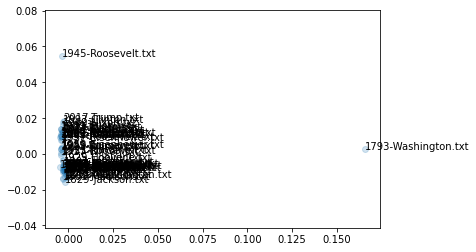

In [25]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.axis('equal');
for i in range(0,58):
    plt.text(X[i,0],X[i,1],inaugural.fileids()[i])